<a href="https://colab.research.google.com/github/mamoonmasud/graph_community/blob/main/GAT(PubMed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
#Checking if cuda is available. If return False, change runtime to GPU
print(torch.cuda.is_available())

True


In [3]:
print(torch.version.cuda)

11.1


In [4]:
#Checking Python Version
! python --version

Python 3.7.12


In [5]:
# Installing DGL
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html 

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 165.0 MB 39 kB/s 


In [6]:
from google.colab import files

In [7]:
# Doing all the imports:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from scipy import sparse as sp
from math import log
import pandas as pd
from sklearn import metrics as skmetrics
import pickle
import numpy as np

import itertools

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [8]:
#from dgl.nn.pytorch.conv import GATConv as GAT

In [9]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [10]:
upload_files()

Saving GAT.py to GAT.py
Saving performance.py to performance.py
Saving Sparsemax.py to Sparsemax.py


['GAT.py', 'performance.py', 'Sparsemax.py']

In [11]:
import GAT
import Sparsemax
import performance as pf


# Graph Neural Network Definition



In [12]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = th.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = th.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')


In [13]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return th.cat(head_outs, dim=1)
        else:
            # merge using average
            return th.mean(torch.stack(head_outs))

In [14]:
class Net(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(Net, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        h = F.log_softmax(h, 1)
        return h

# Data Loading

In [32]:
from dgl.data import PubmedGraphDataset as pubmed
import networkx as nx

data = pubmed()

# features = th.FloatTensor(data.features)
# labels = th.LongTensor(data.labels)
# mask = th.ByteTensor(data.train_mask)
#g1 = data.graph

##
g = data[0]
num_class = data.num_classes

features = g.ndata['feat']

train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
labels = g.ndata['label']

# add self loop
#g.remove_edges_from(nx.selfloop_edges(g))
g  = dgl.remove_self_loop(g)
#g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

comb_mask = torch.zeros(len(train_mask), dtype=torch.bool)

for i in range(len(comb_mask)):
    if test_mask[i] or train_mask[i] or val_mask[i]:
        comb_mask[i] = True


  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [20]:
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())

We have 19717 nodes.
We have 108365 edges.


# Selecting Training Set

In [22]:
percentage_train = 0.1
percentage_val = 0.1

with open("drive/MyDrive/CSCE689/data_pubchem/pubmed_permutation6.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

## Training

In [23]:
loss_function = pf.perm_inv_loss(labels)
import copy

In [24]:
import time

net = GAT.GAT_Net_fast(g=g, in_feats=features.shape[1], hidden_size=100, hidden_layers=2, out_feats=len(np.unique(labels)),
dropout=0.2, batchnorm=False, num_heads=1, residual = False)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(1000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand = pf.rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand = pf.rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>50:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    #loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss = F.nll_loss(logits[mask_train], labels[mask_train])
    loss_ev.append(loss.detach().item())
    #print(np.unique(np.argmax(logits[mask_train].detach().numpy(),1)))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

Epoch 00000 | Loss 1.7746 | Train.Rand 0.0472 | Valid.Rand 0.0446 | Time(s) unknown
Epoch 00001 | Loss 1.1378 | Train.Rand 0.3599 | Valid.Rand 0.3307 | Time(s) unknown
Epoch 00002 | Loss 0.8009 | Train.Rand 0.4578 | Valid.Rand 0.4251 | Time(s) unknown
Epoch 00003 | Loss 0.7881 | Train.Rand 0.4004 | Valid.Rand 0.3599 | Time(s) 0.7357
Epoch 00004 | Loss 0.6489 | Train.Rand 0.4758 | Valid.Rand 0.4205 | Time(s) 0.7336
Epoch 00005 | Loss 0.6136 | Train.Rand 0.5266 | Valid.Rand 0.4517 | Time(s) 0.7390
Epoch 00006 | Loss 0.5707 | Train.Rand 0.5621 | Valid.Rand 0.4859 | Time(s) 0.7368
Epoch 00007 | Loss 0.5497 | Train.Rand 0.5705 | Valid.Rand 0.4735 | Time(s) 0.7376
Epoch 00008 | Loss 0.4643 | Train.Rand 0.5952 | Valid.Rand 0.5175 | Time(s) 0.7397
Epoch 00009 | Loss 0.4748 | Train.Rand 0.6077 | Valid.Rand 0.5256 | Time(s) 0.7378
Epoch 00010 | Loss 0.4621 | Train.Rand 0.6118 | Valid.Rand 0.5130 | Time(s) 0.7397
Epoch 00011 | Loss 0.4445 | Train.Rand 0.6175 | Valid.Rand 0.5227 | Time(s) 0.7412
E

<All keys matched successfully>

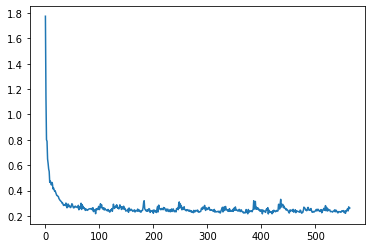

In [25]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)


In [26]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

In [27]:
np.unique(np.argmax(logits[mask_train].detach().numpy(),1))

array([0, 1, 2])

In [30]:
# Visualise predictions
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
a = np.transpose(np.vstack([final_prediction[comb_mask].numpy().argmax(axis=1),labels[comb_mask].numpy()]))
a[a[:,0].argsort()][np.random.choice(range(a.shape[0]),size=10)]

# As can be seen, the graph net predicts correct labels

array([[1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1]])

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


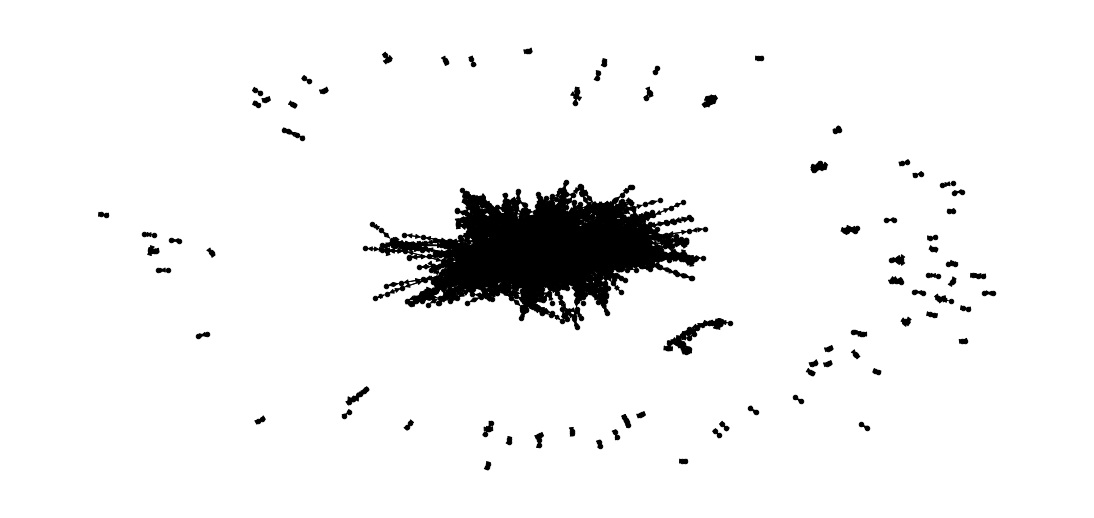

In [31]:
import matplotlib.pyplot as plt


dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)


## Evaluation


In [37]:
# Performnace evaluation functions

def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)
        # print(contingency.todense())
        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))
        # print(nz_val)
        log_contingency_nm = np.log(nz_val)
        # print(log_contingency_nm)
        contingency_nm = nz_val / contingency_sum
        # print(contingency_nm)

        # Don't need to calculate the full outer product, just for non-zeroes
        outer = pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(
            np.int64, copy=False
        )
        # print(outer)
        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
        # print(log_outer)
        mi = (
            contingency_nm * (log_contingency_nm - log(contingency_sum))
            + contingency_nm * log_outer
        )
        # print(mi)
        return mi.sum()

    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")

def compute_performance(labels, logits, splits):
    logits = logits.detach().numpy()
    preds = np.argmax(logits, axis=1)
    labels = labels.numpy()
    pred_sets = {
        "All ": preds,
        "Train": preds[mask_train],
        "Val": preds[mask_val],
        "Test": preds[test_mask],
    }
    label_sets = {
        "All ": labels,
        "Train": labels[mask_train],
        "Val": labels[mask_val],
        "Test": labels[test_mask],
    }
    eval_functions = {
        "Rand-Index": rand_score,
        "Mutual Information": mutual_info_score,
        "Variation of Information": variation_of_information_score,
    }
    scores = {
        subset: {
            name: func(label_sets[subset], pred_sets[subset])
            for name, func in eval_functions.items()
        }
        for subset in pred_sets.keys()
    }
    return scores

def performance_as_df(labels, logits, splits):
    scores = compute_performance(labels, logits, splits)
    return pd.DataFrame(scores)

def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)

In [38]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
performance_as_df(labels,final_prediction,comb_mask)

,All,Train,Val,Test
Rand-Index,0.572766,0.844028,0.541899,0.574670
Mutual Information,0.483926,0.768033,0.456625,0.475153
Variation of Information,1.094712,0.488712,1.142830,1.090551
